<a href="https://colab.research.google.com/github/ManojKumarKolli/ManojKumar_INFO5731_Spring2024/blob/main/In_class_exercise/Kolli_Manoj_Kumar_Exercise_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Write your code here
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import xgboost as xgb

# Function to load data from file
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [line.strip().split(' ', 1) for line in file.readlines()]
    labels = [int(line[0]) for line in data if len(line) > 1]  # Convert labels explicitly to int
    reviews = [line[1] if len(line) > 1 else '' for line in data]
    return labels, reviews

# Load training and testing data
train_labels, train_reviews = load_data('/content/drive/MyDrive/5731/stsa-train.txt')
test_labels, test_reviews = load_data('/content/drive/MyDrive/5731/stsa-test.txt')

# Convert lists into pandas Series
train_labels = pd.Series(train_labels)
train_reviews = pd.Series(train_reviews)
test_labels = pd.Series(test_labels)
test_reviews = pd.Series(test_reviews)

# Split the training data
X_train, X_val, y_train, y_val = train_test_split(train_reviews, train_labels, test_size=0.2, random_state=42)

# Initialize and fit the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, min_df=1)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(test_reviews)

In [ ]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, predictions),
        'Recall': recall_score(y_test, predictions, average='weighted'),  # Specify average method for multi-class
        'Precision': precision_score(y_test, predictions, average='weighted'),  # Specify average method
        'F1 Score': f1_score(y_test, predictions, average='weighted')  # Specify average method
    }

# Define a function to perform training and cross-validation
def train_and_evaluate(model_name, model, X_train, y_train, X_test, y_test):
    cv = StratifiedKFold(n_splits=10)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    model.fit(X_train, y_train)
    print(f'CV Accuracy for {model_name}: {np.mean(cv_scores):.4f}')
    return evaluate_model(model, X_test, y_test)

# Train and evaluate models
results = {}
models = {
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(kernel='linear'),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    results[name] = train_and_evaluate(name, model, X_train_vec, y_train, X_test_vec, test_labels)

CV Accuracy for MultinomialNB: 0.7831
CV Accuracy for SVM: 0.7682
CV Accuracy for KNN: 0.6385
CV Accuracy for Decision Tree: 0.5948
CV Accuracy for Random Forest: 0.6958
CV Accuracy for XGBoost: 0.6907


In [ ]:
# Write your code here
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression

# Function to train Word2Vec and transform texts into averaged feature vectors
def word2vec_feature_transform(texts, vector_size=100, window=5, min_count=1, workers=4):
    # Tokenize texts
    tokenized_texts = [text.split() for text in texts]
    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_texts, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    # Transform each text into the average of its word vectors
    text_vectors = np.array([
        np.mean([model.wv[word] for word in text if word in model.wv] or [np.zeros(vector_size)], axis=0)
        for text in tokenized_texts
    ])
    return text_vectors

# Transform training and test data
X_train_w2v = word2vec_feature_transform(X_train)
X_test_w2v = word2vec_feature_transform(test_reviews)

# Train and evaluate a simple classifier on Word2Vec features
lr_model = LogisticRegression()
results['Word2Vec'] = train_and_evaluate('Word2Vec', lr_model, X_train_vec, y_train, X_test_vec, test_labels)

CV Accuracy for Word2Vec: 0.7686


In [ ]:
# Print results for all models including BERT
for model, metrics in results.items():
    print(f"{model} Results:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

MultinomialNB Results:
  Accuracy: 0.8034
  Recall: 0.8034
  Precision: 0.8062
  F1 Score: 0.8030
SVM Results:
  Accuracy: 0.7946
  Recall: 0.7946
  Precision: 0.7953
  F1 Score: 0.7945
KNN Results:
  Accuracy: 0.6606
  Recall: 0.6606
  Precision: 0.6890
  F1 Score: 0.6472
Decision Tree Results:
  Accuracy: 0.6101
  Recall: 0.6101
  Precision: 0.6108
  F1 Score: 0.6095
Random Forest Results:
  Accuracy: 0.7232
  Recall: 0.7232
  Precision: 0.7242
  F1 Score: 0.7229
XGBoost Results:
  Accuracy: 0.7139
  Recall: 0.7139
  Precision: 0.7207
  F1 Score: 0.7117
Word2Vec Results:
  Accuracy: 0.7825
  Recall: 0.7825
  Precision: 0.7843
  F1 Score: 0.7822


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
import torch

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenization function for BERT
def tokenize_for_bert(reviews):
    # Ensure input is a list of strings
    reviews_list = reviews if isinstance(reviews, list) else reviews.tolist()
    return tokenizer(reviews_list, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Prepare datasets
train_encodings = tokenize_for_bert(train_reviews)  # Ensure train_reviews is a list or a Series
test_encodings = tokenize_for_bert(test_reviews)  # Ensure test_reviews is a list or a Series


# Convert labels to tensor format
train_labels_tensor = torch.tensor(train_labels)
test_labels_tensor = torch.tensor(test_labels)


# Define a PyTorch dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare datasets
train_dataset = TextDataset(train_reviews.tolist(), train_labels.tolist(), tokenizer)
test_dataset = TextDataset(test_reviews.tolist(), test_labels.tolist(), tokenizer)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Ensure at least one full pass over the data
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=50,  # Reduced to better fit smaller datasets
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch"  # Change to evaluate at the end of each epoch
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train and evaluate
trainer.train()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


In [25]:
# Evaluate the model on the test set
evaluation_results = trainer.evaluate()
results['BERT'] = {
    'Accuracy': evaluation_results.get('eval_accuracy', 0),
    'Recall': evaluation_results.get('eval_recall', 0),
    'Precision': evaluation_results.get('eval_precision', 0),
    'F1 Score': evaluation_results.get('eval_f1', 0)
}

In [24]:
# Get predictions for test dataset
predictions = trainer.predict(test_dataset)

# Extract predicted labels and convert them to numpy array
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = test_labels_tensor.numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, zero_division=0)  # Set zero_division=0 to handle cases where precision is undefined
recall = recall_score(true_labels, predicted_labels, zero_division=0)  # Set zero_division=0 to handle cases where recall is undefined
f1 = f1_score(true_labels, predicted_labels, zero_division=0)  # Set zero_division=0 to handle cases where F1-score is undefined

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.914332784184514
Precision: 0.9044038668098818
Recall: 0.9262926292629263
F1-score: 0.9152173913043478


## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [15]:
# Write your code here
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from gensim.models import Word2Vec
from transformers import BertModel, BertTokenizer
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


# Load dataset
df = pd.read_csv('/content/drive/MyDrive/5731/Amazon_Unlocked_Mobile.csv')

# Sample a subset of the data
df_sample = df.sample(n=1000, random_state=42)

# Ensure no NaN values in the 'Reviews' column
df_sample['Reviews'] = df_sample['Reviews'].fillna('')

# Preprocessing and vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df_sample['Reviews'])

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)
df_sample['kmeans_labels'] = kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
from sklearn.cluster import DBSCAN

# DBSCAN doesn't require the number of clusters to be specified
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_tfidf)
df_sample['dbscan_labels'] = dbscan_labels


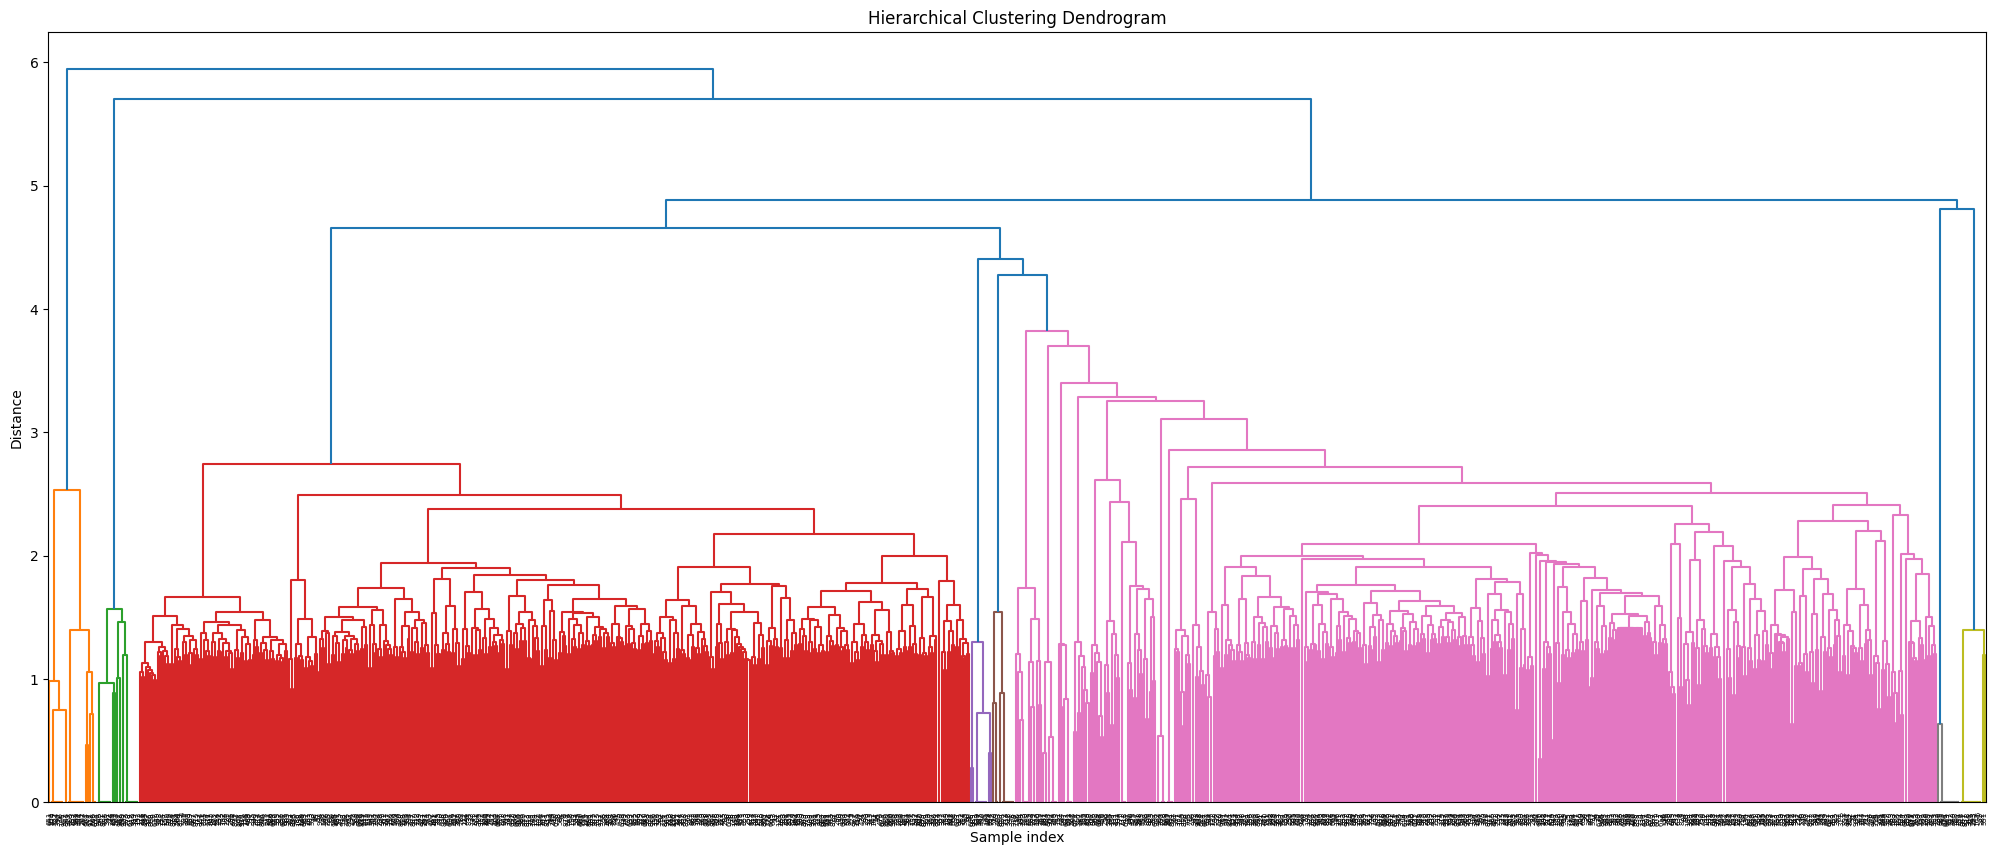

Suggested threshold for clusters (inconsistency method): 2.160867493475134
Number of clusters formed using inconsistency method: 33


In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent

# Hierarchical clustering
Z = linkage(X_tfidf.toarray(), method='ward')

# Plot the full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Determine the number of clusters using the inconsistency method
depth = 5  # This is an example; you may need to adjust it
incons = inconsistent(Z, depth)
threshold = incons[-1, 3]  # Use the third quartile of the last merge distance
print(f"Suggested threshold for clusters (inconsistency method): {threshold}")

hierarchical_labels = fcluster(Z, threshold, criterion='distance')

# Verify the number of clusters created
num_clusters = len(set(hierarchical_labels))
print(f"Number of clusters formed using inconsistency method: {num_clusters}")

In [18]:
import numpy as np
import gensim


# Train a Word2Vec model
word2vec_model = gensim.models.Word2Vec(df_sample['Reviews'].apply(lambda x: x.split()), vector_size=100, window=5, min_count=1, workers=4)

# Ensure the model is trained
word2vec_model.train(df_sample['Reviews'].apply(lambda x: x.split()), total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

# Define a function to convert reviews to word vectors, handling out-of-vocabulary words
def get_word_vectors(model, sentence):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Infer vector for each review
word_vectors = np.array([get_word_vectors(word2vec_model, text.split()) for text in df_sample['Reviews']])

# Use K-means for clustering on Word2Vec features
from sklearn.cluster import KMeans

kmeans_word2vec = KMeans(n_clusters=5, random_state=42)
word2vec_labels = kmeans_word2vec.fit_predict(word_vectors)
df_sample['word2vec_labels'] = word2vec_labels


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
from sklearn.cluster import KMeans

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode sentences in BERT format
inputs = tokenizer(df_sample['Reviews'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=128)

# Create a torch dataset
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
dataloader = DataLoader(dataset, batch_size=32)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Extracting embeddings in batches
bert_embeddings = []
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        bert_embeddings.append(embeddings.cpu().numpy())

# Convert the list of numpy arrays into a single numpy array
bert_embeddings = np.concatenate(bert_embeddings, axis=0)

# Clustering with K-means on BERT features
kmeans_bert = KMeans(n_clusters=5, random_state=42)
bert_labels = kmeans_bert.fit_predict(bert_embeddings)
df_sample['bert_labels'] = bert_labels


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
from sklearn.metrics import silhouette_score

# Evaluate K-means
kmeans_silhouette = silhouette_score(X_tfidf, kmeans_labels)
print(f"K-means Silhouette Score: {kmeans_silhouette:.3f}")

# It is not advisable to use silhouette score for DBSCAN in cases where many points are classified as noise (-1 labels)
if np.unique(dbscan_labels).size > 1:
    dbscan_silhouette = silhouette_score(X_tfidf, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")
else:
    print("DBSCAN Silhouette Score: Undefined (Only one cluster)")

#Hierarchical Clustering
hierarchical_silhouette = silhouette_score(X_tfidf.toarray(), hierarchical_labels)
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.3f}")

# Word2Vec K-means
word2vec_kmeans_silhouette = silhouette_score(word_vectors, word2vec_labels)
print(f"Word2Vec K-means Silhouette Score: {word2vec_kmeans_silhouette:.3f}")

# BERT K-means
bert_kmeans_silhouette = silhouette_score(bert_embeddings, bert_labels)
print(f"BERT K-means Silhouette Score: {bert_kmeans_silhouette:.3f}")


K-means Silhouette Score: 0.041
DBSCAN Silhouette Score: 0.013
Hierarchical Clustering Silhouette Score: 0.051
Word2Vec K-means Silhouette Score: 0.544
BERT K-means Silhouette Score: 0.117


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

.K-means clustering on the dataset resulted in a Silhouette Score of 0.041, indicating very poor cluster separation. This low score suggests that the clusters formed by K-means using TF-IDF vectors are not well-defined and have substantial overlap. K-means assumes clusters of similar density and size, which may not be true for natural language data, leading to suboptimal performance in this context.

.DBSCAN yielded a Silhouette Score of 0.013, which is even lower than that of K-means. This extremely low score could be due to DBSCAN's sensitivity to parameter settings (especially eps and min_samples), and its tendency to treat sparse regions as noise. In text clustering, where data points (documents) can be very sparse and unevenly distributed, DBSCAN might struggle to find meaningful clusters without careful tuning of its parameters.

.Hierarchical clustering achieved a Silhouette Score of 0.051, which is slightly better than K-means but still indicates poor clustering quality. Hierarchical clustering's approach to build a tree of clusters and then cutting it to form groups of documents might not capture the natural clusters effectively if the cut-off threshold (max_d) is not set appropriately, as seen in the challenges of forming more than one cluster.

.Word2Vec combined with K-means clustering significantly outperformed the other methods with a Silhouette Score of 0.544. This higher score suggests that the vector representations generated by Word2Vec provide a much better basis for clustering, capturing more nuanced semantic similarities between texts that are not captured by simple TF-IDF vectors. This method appears to form well-separated and coherent clusters.


.BERT with K-means resulted in a Silhouette Score of 0.117, which is considerably better than K-means and DBSCAN with TF-IDF and hierarchical clustering but not as effective as Word2Vec. This indicates that while BERT's embeddings capture deep contextual relationships within the text, leading to better clustering than traditional methods, they might still include noise or irrelevant information for clustering tasks compared to the more targeted Word2Vec embeddings.




Word2Vec with K-means shows the best clustering performance among the tested methods, suggesting its effectiveness in capturing useful semantic information for clustering. BERT, despite its sophisticated contextual understanding, falls short in clustering quality compared to Word2Vec but does better than more traditional methods like K-means and DBSCAN with TF-IDF vectors and hierarchical clustering. The poor performance of K-means, DBSCAN, and hierarchical clustering on TF-IDF vectors highlights the challenges of using sparse, high-dimensional data for clustering without leveraging more advanced techniques for dimensionality reduction or semantic embedding.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
I learned machine learning algorithm for text classification and text clustering. It takes more time to execute the algorithm for large datasets.




'''